# Tempest Extreme experiment with NextGEMS data
Data have been already preprocessed to 1x1 grid on Levante

We start by reading and putting together into a single netcdf file

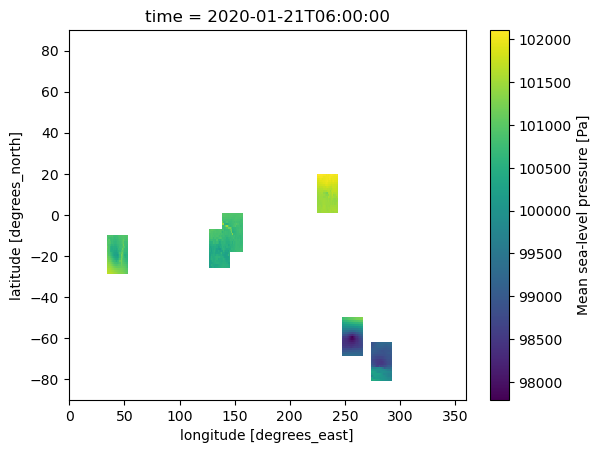

In [1]:
import xarray as xr
import os
import subprocess
from time import time
from glob import glob

from functionsTCs import *

# path to input directory
indir='/home/b/b382216/scratch/regrid'
tmpdir='/home/b/b382216/scratch/tmpdir'
fulldir='/home/b/b382216/scratch/fullres'

time = '000600'
infile = os.path.join(indir, f'regrid+{time}_*.nc')
outfile = os.path.join(tmpdir, time + '.nc')
txtfile = os.path.join(tmpdir, 'output_' + time + '.txt')
mslfile=os.path.join(fulldir, f'ICMGGhqys+{time}_msl.nc')
storefile = os.path.join(tmpdir, 'TC_' + time + '.nc')

# read and save the netcdf file to mimic the time lost by the FDB query
tempest_dictionary = readwrite_from_lowres(infile, outfile)
tempest_command = run_detect_nodes(tempest_dictionary, outfile, txtfile)
tempest_nodes = read_lonlat_nodes(txtfile) 

xfield = xr.open_mfdataset(outfile)['MSL']

# set the dimension in degrees of lon/lat of the box around the TCs centre
boxdim=10
gfield = xfield * 0
for k in range(0, len(tempest_nodes['lon'])) :
    box = lonlatbox(tempest_nodes['lon'][k], tempest_nodes['lat'][k], boxdim)
    gfield = gfield + xr.where((xfield.lon > box[0]) & (xfield.lon < box[1]) & (xfield.lat > box[2]) & (xfield.lat < box[3]), True, False)

xfield = xfield.where(gfield>0)

xfield.plot()

In [4]:
import xarray as xr
import os
import subprocess
from time import time
from glob import glob

from functionsTCs import *

# path to input directory
indir='/home/b/b382216/scratch/regrid'
tmpdir='/home/b/b382216/scratch/tmpdir'
fulldir='/home/b/b382216/scratch/fullres'

boxdim=10

# variables to be stored
varlist = ['psl', 'uas', 'vas']

# dicitonary with the original filenames
original_dictionary = {'psl': 'msl', 'uas': '10u', 'vas': '10v' }

# loop on timerecords
for t in range(120*4*30*8, ((120*4*30*8)+(120*4*14)), 120) : 

    tttt = str(t).zfill(6)
    print(tttt)
    # path definition
    original_file = os.path.join(indir, f'regrid+{tttt}_*.nc')
    netcdf_file = os.path.join(tmpdir, tttt + '.nc')
    txt_file = os.path.join(tmpdir, 'output_' + tttt + '.txt')

    # read and save the netcdf file to mimic the time lost by the FDB query
    tempest_dictionary = readwrite_from_lowres(original_file, netcdf_file)

     # run tempest extremes
    tempest_command = run_detect_nodes(tempest_dictionary, netcdf_file, txt_file)
    tempest_nodes = read_lonlat_nodes(txt_file)
    id = tempest_nodes['date']
    print(id)
    
    for var in varlist: 

        varname = tempest_dictionary[var]
        varfile = original_dictionary[var]
    # take the LOW res files to find the bug in the reordered tracks later


        fullres_file=os.path.join(indir, f'regrid+{tttt}_{varfile}.nc')
        #print(fullres_field)
        #prec_fullres_file=os.path.join(fulldir, f'ICMGGhqys+{tttt}_v10.nc')
   
        # get the full res field and store the required values around the Nodes
        fullres_field = xr.open_mfdataset(fullres_file)[varname]
        xfield = store_fullres_field(0, fullres_field, tempest_nodes, boxdim)

        print('Storing output')
        store_file = os.path.join(tmpdir, f'TC_{varname}_{id}.nc')
        write_fullres_field(xfield, store_file)
  
    clean_files([netcdf_file])

    ##reinit xfield
    #xfield = 0


115200
2020091600
<xarray.DataArray 'MSL' (time: 1, lat: 180, lon: 360)>
dask.array<open_dataset-c8acdf2cb617b4b3b42f2b693e4cca3cMSL, shape=(1, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-09-16
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:  Mean sea-level pressure
    units:      Pa
    code:       151
    table:      128
Storing output
<xarray.DataArray 'MSL' (time: 1, lat: 180, lon: 360)>
dask.array<open_dataset-c8acdf2cb617b4b3b42f2b693e4cca3cMSL, shape=(1, 180, 360), dtype=float32, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-09-16
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes

In [2]:

track_file = os.path.join(tmpdir, 'track.txt')
filenames = glob(os.path.join(tmpdir,'output_*'))

# MAXGAP set to 6 h to see if there are problem in the concatenation of outputs from detect nodes
stitch_string = run_stitch_nodes(filenames, track_file)
# output track. txt OK!

Arguments:
  --in <string> ["full_nodes.txt"] 
  --in_list <string> [""] 
  --in_connect <string> [""] 
  --out <string> ["/home/b/b382216/scratch/tmpdir/track.txt"] 
  --in_fmt <string> ["lon,lat,slp,wind"] 
  --range <double> [8.000000] (degrees)
  --mintime <string> ["54h"] 
  --time_begin <string> [""] 
  --time_end <string> [""] 
  --min_endpoint_dist <double> [0.000000] (degrees)
  --min_path_dist <double> [0.000000] (degrees)
  --maxgap <string> ["24h"] 
  --threshold <string> ["wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10"] [col,op,value,count;...]
  --caltype <string> ["standard"] (none|standard|noleap|360_day)
  --allow_repeated_times <bool> [false] 
  --out_file_format <string> ["gfdl"] (gfdl|csv|csvnohead)
------------------------------------------------------------
Parsing thresholds
..wind greater than or equal to 10.000000 at least 10 time(s)
..lat less than or equal to 50.000000 at least 10 time(s)
..lat greater than or equal to -50.000000 at least 10 time(s)
..Done
L

Get the lon/lat from the Stitch Nodes output .txt file

In [3]:
 # open the output file and extract the required lon/lat
track_file = os.path.join(tmpdir, 'track.txt')
# reordered_tracks is a dict containing the concatenated (in time) tracks
# at eatch time step are associated all lons/lats
reordered_tracks = reorder_tracks(track_file)

#for values in reordered_tracks.values():
   #print(values)


# initialise full_res fields at 0 before the loop
msl_xfield = 0
u10_xfield = 0
v10_xfield = 0
for id in reordered_tracks.keys():

    print(id)
    msl_fullres_file = os.path.join(tmpdir, f'TC_MSL_{id}.nc')
    msl_fullres_field = xr.open_mfdataset(msl_fullres_file)['MSL']
    u10_fullres_file = os.path.join(tmpdir, f'TC_10u_{id}.nc')
    u10_fullres_field = xr.open_mfdataset(u10_fullres_file)['U10M']
    v10_fullres_file = os.path.join(tmpdir, f'TC_10v_{id}.nc')
    v10_fullres_field = xr.open_mfdataset(v10_fullres_file)['V10M']
    

    # get the full res field and store the required values around the Nodes
    msl_xfield = store_fullres_field_tracks(msl_xfield, msl_fullres_field, reordered_tracks, boxdim)
    u10_xfield = store_fullres_field_tracks(u10_xfield, u10_fullres_field, reordered_tracks, boxdim)
    v10_xfield = store_fullres_field_tracks(v10_xfield, v10_fullres_field, reordered_tracks, boxdim)

print('Storing output')

# store the file
store_file_msl = os.path.join(tmpdir, f'tempest_tracks_msl.nc')
store_file_u10 = os.path.join(tmpdir, f'tempest_tracks_10u.nc')
store_file_v10 = os.path.join(tmpdir, f'tempest_tracks_10v.nc')
write_fullres_field(msl_xfield, store_file_msl)
write_fullres_field(u10_xfield, store_file_u10)
write_fullres_field(v10_xfield, store_file_v10)

2020091600
2020091606
2020091612
2020091618
2020091700
2020091706
2020091712
2020091718
2020091800
2020091806
2020091812
2020091818
2020091900
2020091906
2020091912
2020091918
2020092000
2020092006
2020092012
2020092018
2020092100
2020092106
2020092112
2020092118
2020092200
2020092206
2020092212
2020092218
2020092300
2020092306
2020092312
2020092318
2020092400
2020092406
2020092412
2020092418
2020092500
2020092506
2020092512
2020092518
2020092600
2020092606
2020092612
2020092618
2020092700
2020092706
2020092712
2020092718
2020092800
2020092806
2020092812
2020092818
2020092900
2020092906
2020092912
2020092918
Storing output
